# Strategy

- S&P 500 (SPY) vs Intermediate-term US Treasuries (IEF)
- Gold (GLD) vs Long-term US Treasuries (TLT)
- US Real Estate (VNQ) vs Intermediate-term US Treasuries (IEF)


![strategy_params](strategy_params.png)


[More info](https://allocatesmartly.com/stokens-active-combined-asset-strategy/)

IEF - 7-10 years bonds

TLT - 20+ bonds


In [1]:
CONFIG = {
  'SPY': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'},
  'GLD': {'upper': 252, 'lower': 126, 'defensive_asset': 'TLT'},
  'VNQ': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'}
}

In [2]:
import numpy as np

ASSETS = set(np.array([
  [asset, config['defensive_asset']] 
    for (asset, config) in CONFIG.items()
]).flat)

ASSETS

{'GLD', 'IEF', 'SPY', 'TLT', 'VNQ'}

# Load assets history

We will use yahoo finance client to load dividends and prices history for our `ASSETS`.

In [3]:
# pip install --user pandas numpy datetime scipy pandas_datareader yfinance

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta

yf.pdr_override()

In [4]:
def load_max_history(assets):
  df = None

  for asset in assets:
    data = yf.Ticker(asset).history(period='max')
    columns = pd.MultiIndex.from_product(
      [data.columns, [asset]],
      names=['property', 'asset']
    )
    multi_level_df = pd.DataFrame(data.values, index=data.index, columns=columns)
    # display(multi_level_df.columns.to_numpy())
    if df is None:
      df = multi_level_df
    else:
      df = df.join(multi_level_df)

  df = df[sorted(df.columns)]
  return df.dropna()

df = load_max_history(ASSETS)[['Close', 'Dividends']]
df.head()

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2004-11-18  44.380001  55.061234  84.752548  51.618938  25.282881       0.0   
2004-11-19  44.779999  54.759556  83.810349  51.207008  25.021566       0.0   
2004-11-22  44.950001  54.798042  84.210052  51.473942  25.194233       0.0   
2004-11-23  44.750000  54.746696  84.338524  51.537758  25.301544       0.0   
2004-11-24  45.049999  54.823723  84.538383  51.537758  25.740192       0.0   

property                        
asset       IEF  SPY  TLT  VNQ  
Date                            
2004-11-18  0.0  0.0  0.0  0.0  
2004-11-19  0.0  0.0  0.0  0.0  
2004-11-22  0.0  0.0  0.0  0.0  
2004-11-23  0.0  0.0  0.0  0.0  
2004-11-24  0.0  0.0  0.0  0.0

Create upper and lower channels for risk-on assets defined in the `CONFIG`.

In [5]:
for (asset, config) in CONFIG.items():
  df['Upper Channel', asset] = df['Close', asset].shift(1).rolling(window=config['upper']).max()
  df['Lower Channel', asset] = df['Close', asset].shift(1).rolling(window=config['lower']).min()

df = df[sorted(df.columns)]
df.iloc[250:].head() # deliberate shift to check the first moment where 252 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-11-15  46.660000  55.254707  89.464455  54.242725  29.501312       0.0   
2005-11-16  47.779999  55.534782  89.645950  54.813068  29.333391       0.0   
2005-11-17  48.480000  55.641422  90.480751  54.946552  29.817358       0.0   
2005-11-18  48.459999  55.508095  90.836479  54.691750  29.925999       0.0   
2005-11-21  48.990002  55.614758  91.293839  54.855549  30.074139       0.0   

property                       Lower Channel                        \
asset       IEF  SPY  TLT  VNQ           GLD        SPY        VNQ   
Date                                                                 
2005-11-15  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-16  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-17  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664766   
2005-11-18  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664766   
2005-11-21  0.0  0.0  0.0  0.0     41.529999  81.930779  24.664766   

property   Upper Channel                        
asset                GLD        SPY        VNQ  
Date                                            
2005-11-15           NaN  90.155060  30.903223  
2005-11-16           NaN  90.155060  30.903223  
2005-11-17     47.779999  90.155060  30.903223  
2005-11-18     48.480000  90.480751  30.903223  
2005-11-21     48.480000  90.836479  30.903223

In [6]:
cash = 50000 # initial cash
portfolio = []

def flatten_portfolio(portfolio): 
  dict = {}
  for item in portfolio:
    dict[item['asset']] = item['amount']
  return dict

results = {'portfolio_value': [], 'cash': [], 'portfolio': []}

for x in range(0, df.shape[0]):

  today = df.iloc[x]
  close_price = today['Close']
  upper_channel = today['Upper Channel']
  lower_channel = today['Lower Channel']
  dividends = today['Dividends']

  # initialize portfolio - start with risk on
  if len(portfolio) == 0:
    portfolio = [{}] * len(CONFIG)
    fraction = cash / len(CONFIG)

    for (index, (asset, config)) in enumerate(CONFIG.items()):
      price = close_price[asset]
      amount = np.floor(fraction / price)
      cash -= amount * price
      portfolio[index] = {'asset': asset, 'amount': amount}

    portfolio_value = cash
    for item in portfolio:
      portfolio_value += close_price[item['asset']] * item['amount']

    results['portfolio_value'].append(portfolio_value)
    results['cash'].append(cash)
    results['portfolio'].append(flatten_portfolio(portfolio))

    continue

  # add dividends
  for item in portfolio:
    maybe_divs = dividends[item['asset']]
    if not np.isnan(maybe_divs):
      cash += (item['amount'] * maybe_divs) * 0.85 # we pay 15% tax on dividends here (but it can vary a lot depending on circumstances)
    # TODO rebalance if necessary

  # calculate portfolio value
  portfolio_value = cash
  for item in portfolio:
    portfolio_value += close_price[item['asset']] * item['amount']

  # check if need to replace some assets with defensive assets
  new_assets = [None] * 3
  for (index, (asset, config)) in enumerate(CONFIG.items()):
    if close_price[asset] > upper_channel[asset] and portfolio[index]['asset'] != asset:
      new_assets[index] = asset
    elif close_price[asset] < lower_channel[asset] and portfolio[index]['asset'] != config['defensive_asset']:
      new_assets[index] = config['defensive_asset']

  needs_rotation = not all(v is None for v in new_assets)
  if needs_rotation:
    fraction = portfolio_value / 3
    for (index, item) in enumerate(portfolio):
      # do we need to replace item completely?
      if not new_assets[index] is None and item['asset'] != new_assets[index]:
        # sell current asset
        cash += item['amount'] * close_price[item['asset']]
        # buy new asset
        # TODO may be unified with initialization
        asset = new_assets[index]
        price = close_price[asset]
        amount = np.floor(fraction / price)
        cash -= amount * price
        # store new asset
        item['asset'] = asset 
        item['amount'] = amount

      # do we need to rebalance?
      else:
        asset = item['asset']
        price = close_price[asset]
        new_amount = np.floor(fraction / price)
        diff = item['amount'] - new_amount
        if diff != 0:
          # rebalance
          # diff > 0 => item['amount'] > new_amount => sell
          # diff < 0 => item['amount'] < new_amount => buy
          cash += diff * price
          item['amount'] = new_amount

    # calculate updated portfolio value
    portfolio_value = cash
    for item in portfolio:
      portfolio_value += close_price[item['asset']] * item['amount']

  results['portfolio_value'].append(portfolio_value)
  results['cash'].append(cash)
  results['portfolio'].append(flatten_portfolio(portfolio))

result_df = pd.DataFrame(results, index=df.index)

# dumping results dataframe to HTML can be good for debug purposes
#
# with open('out.html', 'w') as file:
#   file.write(df.join(result_df).to_html())

result_df.head()

,portfolio_value,cash,portfolio
Date,,,
2004-11-18,50000.000000,84.581713,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}"
2004-11-19,49793.121815,84.581713,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}"
2004-11-22,50049.001795,84.581713,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}"
2004-11-23,50069.900011,84.581713,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}"
2004-11-24,50510.641390,84.581713,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}"


In [7]:
result_df.tail()

,portfolio_value,cash,portfolio
Date,,,
2022-01-07,406455.429287,6326.746395,"{'SPY': 297.0, 'TLT': 800.0, 'VNQ': 1332.0}"
2022-01-10,405710.698971,6326.746395,"{'SPY': 297.0, 'TLT': 800.0, 'VNQ': 1332.0}"
2022-01-11,407956.411190,6326.746395,"{'SPY': 297.0, 'TLT': 800.0, 'VNQ': 1332.0}"
2022-01-12,408066.761989,6326.746395,"{'SPY': 297.0, 'TLT': 800.0, 'VNQ': 1332.0}"
2022-01-13,406862.196682,6326.746395,"{'SPY': 297.0, 'TLT': 800.0, 'VNQ': 1332.0}"


# Total annualized returns

In [8]:
first = result_df.iloc[0]
last = result_df.iloc[-1]

years = (last.name - first.name).days / 365.25

annualized_return = (last['portfolio_value']  / first['portfolio_value']) ** (1/years) - 1

print(
  """Annualized return is: %.2f%%
over the period of %.2f years
from %s to %s""" % (
    100 * annualized_return,
    years,
    date.fromtimestamp(first.name.timestamp()), 
    date.fromtimestamp(last.name.timestamp())
  )
)


Annualized return is: 13.00%
over the period of 17.15 years
from 2004-11-18 to 2022-01-13


# Overall performance

Initial investment at 2004-11-18: 10000
Last value at 2022-01-13: 81372.44


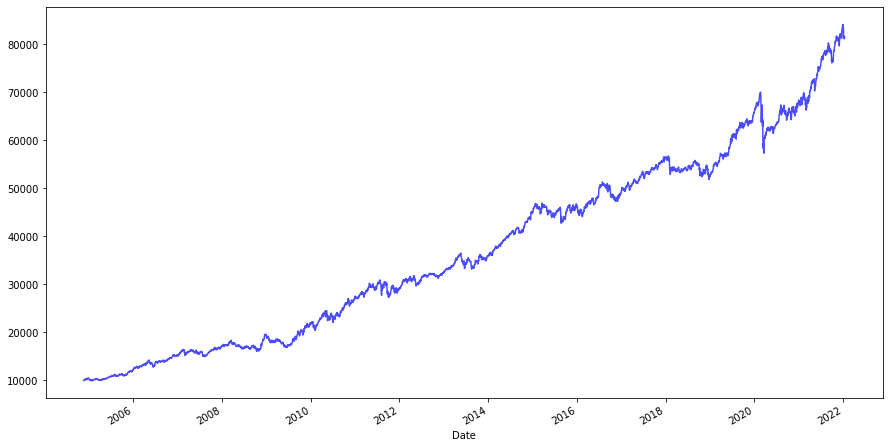

In [9]:
log_returns = np.log(result_df.portfolio_value).diff()

cum_returns = log_returns.cumsum() 

CAPITAL = 10000

perf = CAPITAL * np.exp(cum_returns)
plt.figure()
perf.plot(figsize=(15,8), color='b', alpha=0.7)

print(f'Initial investment at {perf.index[0].date()}: {CAPITAL}')
print(f'Last value at {perf.index[-1].date()}: {perf[-1]:.2f}')

In [10]:
TRADING_DAYS_YEARLY = 252
# RISK_FREE_RATE = 0.02
RISK_FREE_RATE = 0.00

annual_return = np.exp(log_returns.mean() * TRADING_DAYS_YEARLY) - 1
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS_YEARLY)

sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(TRADING_DAYS_YEARLY)
sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

print(
  f"""Annulaized return {(annual_return * 100):.2f}%
Annualized volatility {(annual_volatility * 100):.2f}%
Sharpe ratio {sharpe_ratio:.2f}
Sortino ratio {sortino_ratio:.2f}
""" 
)

Annulaized return 13.01%
Annualized volatility 10.90%
Sharpe ratio 1.19
Sortino ratio 1.59



# Returns by month/by year

In [11]:

def montly_results(result_df):
  initial_value = result_df['portfolio_value'][0]

  grouping = pd.MultiIndex.from_tuples(
    zip(result_df.index.year, result_df.index.month),
    names=['year', 'month']
  )

  by_month = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_month = by_month.join(by_month.shift(1).add_prefix('prev_')).fillna(initial_value)

  table = pd.DataFrame(
    {
      'change': 100 * (by_month['portfolio_value'] / by_month['prev_portfolio_value'] - 1),
    },
    index = grouping
  ).dropna().reset_index()

  montly_results = table.pivot_table(index=['year'], columns=['month'], values=['change'])

  grouping = result_df.index.year
  by_year = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_year = by_year.join(by_year.shift(1).add_prefix('prev_')).fillna(initial_value)

  montly_results['total'] = 100 * (by_year['portfolio_value'] / by_year['prev_portfolio_value'] - 1)

  return montly_results

pd.options.display.float_format = lambda x: 'N/A' if np.isnan(x) else '{:,.2f}%'.format(x)
display(montly_results(result_df))
pd.options.display.float_format = None 


change                                                                 \
month      1      2      3      4      5      6      7      8      9     10   
year                                                                          
2004     N/A    N/A    N/A    N/A    N/A    N/A    N/A    N/A    N/A    N/A   
2005  -4.79%  2.73% -0.87%  1.66%  0.98%  3.80%  3.27% -1.38%  3.84% -1.92%   
2006   6.38%  0.41%  3.73%  3.11% -2.16%  0.68%  2.48%  1.28%  0.57%  3.37%   
2007   4.28% -0.73% -0.35%  1.76%  0.06% -3.35% -3.21%  1.70%  5.14%  3.35%   
2008   2.22%  2.85% -1.03% -2.73% -1.26% -0.82%  0.77% -1.18%  1.30% -5.32%   
2009  -7.10% -0.67%  3.80% -3.76% -2.21% -0.66%  2.74%  6.85%  4.34% -0.93%   
2010  -3.45%  3.94%  5.76%  4.84% -3.41% -1.98%  3.44%  0.05%  6.33%  3.99%   
2011  -0.31%  4.58%  0.38%  5.72% -0.43% -1.94%  2.69%  0.73% -9.01%  5.55%   
2012   5.28%  0.04%  2.88%  0.69% -4.30%  3.12%  2.40%  0.45% -0.02% -1.00%   
2013   1.95%  1.29%  2.69%  4.33% -3.11% -1.44%  1.62% -3.69%  3.10%  3.63%   
2014   1.41%  3.51%  1.13%  1.88%  2.44%  1.67% -0.26%  3.69% -2.40%  4.68%   
2015   3.53% -0.84%  0.67% -2.33% -0.16% -2.63%  3.74% -4.32%  1.06%  4.71%   
2016  -1.54% -0.74%  3.87%  0.58% -0.85%  5.88%  3.27% -2.34%  0.01% -3.44%   
2017   0.78%  3.06% -0.55%  0.97%  0.89%  1.74%  0.95%  1.13%  0.45%  0.51%   
2018  -0.59% -4.10% -0.18% -0.52%  0.81% -0.13%  1.02%  2.44% -0.96% -4.23%   
2019   4.21% -0.25%  4.49% -0.23%  0.23%  5.08%  1.05%  3.35%  0.40%  1.96%   
2020   1.89% -5.02% -5.24%  2.63%  1.16%  1.03%  4.41%  1.04% -2.40% -1.46%   
2021  -1.39%  0.36%  1.78%  5.33%  0.55%  3.39%  3.55%  1.68% -4.16%  5.64%   
2022  -3.24%    N/A    N/A    N/A    N/A    N/A    N/A    N/A    N/A    N/A   

                     total  
month     11     12         
year                        
2004   0.94%  3.20%  4.17%  
2005   4.58%  3.30% 15.77%  
2006   4.38%  0.38% 27.26%  
2007  -0.45%  2.48% 10.77%  
2008  10.34%  8.85% 13.71%  
2009   8.50%  1.22% 11.60%  
2010   0.05%  5.00% 26.63%  
2011  -0.64% -0.52%  6.09%  
2012   0.48%  1.56% 11.85%  
2013  -1.16%  1.52% 10.85%  
2014   2.46%  2.11% 24.50%  
2015  -0.22%  0.63%  3.49%  
2016  -1.33%  3.22%  6.31%  
2017   2.20%  1.68% 14.67%  
2018   2.82% -3.02% -6.70%  
2019  -0.37%  2.90% 25.10%  
2020   1.24%  5.04%  3.77%  
2021  -0.18%  4.81% 23.02%  
2022     N/A    N/A -3.24%

# Drawdown analysis

Text(0, 0.5, 'Drawdown, %')

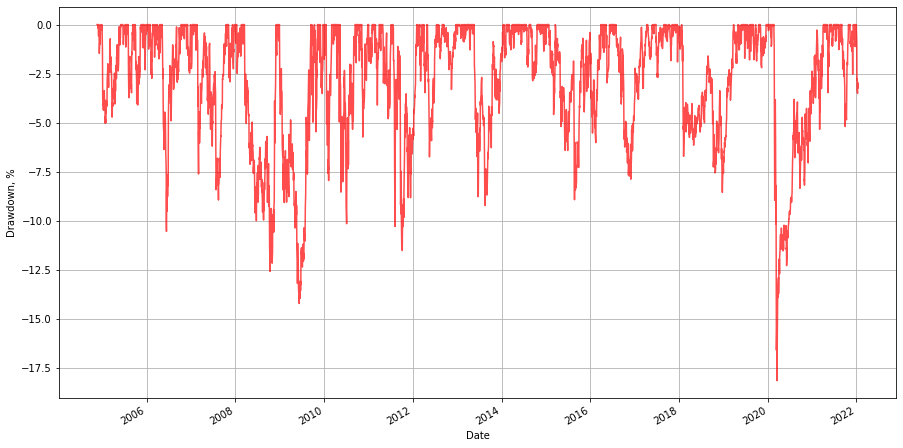

In [12]:
last_peak = cum_returns.cummax()

log_dd = cum_returns - last_peak

pct_dd = (np.exp(log_dd) - 1) * 100

ax = pct_dd.plot(figsize=(15,8), color='r', alpha=0.7)
ax.grid(axis='both')
ax.set_ylabel('Drawdown, %')

# plt.savefig('drawdown_evaluation.svg')


## Longest/max drawdowns

In [13]:

def find_true_streaks(array):
  # finds all "True" streaks in array from longest to shortest

  masked = np.concatenate(([False], array, [False]))       
  true_streaks = np.flatnonzero(masked[1:] != masked[:-1]).reshape(-1, 2) 
  ends = true_streaks[:,1]
  true_streaks_descending = (true_streaks[:,1] - true_streaks[:,0]).argsort()[::-1]
  return true_streaks[true_streaks_descending]

dd_streaks = find_true_streaks(pct_dd.values != 0)

def print_streak(n):
  start, end = dd_streaks[n]
  days = (pct_dd.index[end] - pct_dd.index[start]).days
  years = days / 365.25
  months = years * 12

  print(
    f"""#{n + 1}: Drawdown: {days} days = {months:.2f} months = {years:.2f} years
From {pct_dd.index[start].date()} to {pct_dd.index[end].date()}""" 
  )

print("Longest drawdowns")
for i in range(5):
  if dd_streaks.size <= i: break
  print_streak(i)

if dd_streaks.size == 0:
  print("No drawdown found")

print()
max_dd_index = np.argmin(pct_dd)
print(f"""Max drawdown {pct_dd.iloc[max_dd_index]:.2f}% on {pct_dd.index[max_dd_index].date()}""")

Longest drawdowns
#1: Drawdown: 427 days = 14.03 months = 1.17 years
From 2018-01-24 to 2019-03-27
#2: Drawdown: 406 days = 13.34 months = 1.11 years
From 2020-02-24 to 2021-04-05
#3: Drawdown: 372 days = 12.22 months = 1.02 years
From 2015-03-23 to 2016-03-29
#4: Drawdown: 260 days = 8.54 months = 0.71 years
From 2008-03-18 to 2008-12-03
#5: Drawdown: 258 days = 8.48 months = 0.71 years
From 2008-12-31 to 2009-09-15

Max drawdown -18.17% on 2020-03-19


## Drawdown quantiles

Quantiles:
50.0% of time expected drawdown is no more than 2.33% theoretically or 2.47% actually
75.0% of time expected drawdown is no more than 4.66% theoretically or 5.11% actually
95.0% of time expected drawdown is no more than 10.07% theoretically or 9.38% actually
99.0% of time expected drawdown is no more than 15.48% theoretically or 12.38% actually
Max DD was 18.17%
Last DD (2022-01-13) was 3.24%


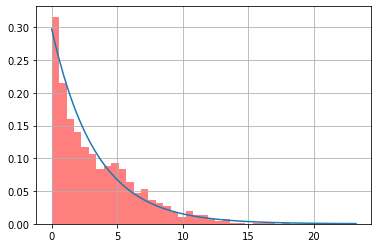

In [14]:
from scipy.stats import expon

nonzero_dd_days = -pct_dd[pct_dd < 0].sort_values()
size = nonzero_dd_days.size

nonzero_dd_days.hist(bins=32, alpha=0.5, density=True, color='red')

params = expon.fit(nonzero_dd_days)

def quantile(p):
  return expon.ppf(p, *params)

xs = np.linspace(quantile(0.001), quantile(0.999), 100)
plt.plot(xs, expon.pdf(xs, *params))

def print_quantile(p):
  theoretical = quantile(p)
  real = nonzero_dd_days[int(size * (1 - p))]
  print(f'{p * 100}% of time expected drawdown is no more than {theoretical:.2f}% theoretically or {real:.2f}% actually')

print('Quantiles:')
for p in [0.50, 0.75, 0.95, 0.99]:
  print_quantile(p)

print(f'Max DD was {nonzero_dd_days[0]:.2f}%')
print(f'Last DD ({pct_dd.index[-1].date()}) was {-pct_dd[-1]:.2f}%')